In [1]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
class ConstantLR:
    def __init__(self, init_lr):
        self.init_lr = init_lr
        self.crnt_lr = self.init_lr

    def get_lr(self):
        return [self.crnt_lr]

    def step(self):
        pass


class LinearLR:
    def __init__(self, init_lr, epoch, eta_min):
        self.init_lr = init_lr
        self.crnt_lr = init_lr

        tot_diff = init_lr - eta_min
        self.diff = tot_diff / (epoch-1)

    def get_lr(self):
        return [self.crnt_lr]

    def step(self):
        self.crnt_lr -= self.diff

        
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer = torch.nn.Linear(10, 20)
        self.t = 1
    
    def forward(self,x=1):
        return self.t

In [3]:
def plot_lr(root, lr):
    cosine, linear, constant = [], [], []

    tmp_model = Model()
    tmp_loss = torch.tensor(0., requires_grad=True)
    tmp_opt = torch.optim.SGD(tmp_model.parameters(), lr=lr)
    s1 = CosineAnnealingLR(tmp_opt, 300, eta_min=5e-6, last_epoch=-1)
    s2 = server_lr_scheduler = LinearLR(lr, 300, eta_min=5e-6)
    s3 = ConstantLR(lr)

    for i in range(300):
        cosine.append(s1.get_lr())
        linear.append(s2.get_lr())
        constant.append(s3.get_lr())

        s1.step()
        s2.step()
        s3.step()

    fig = plt.figure(figsize=(8, 6))
    plt.xticks([50 * x for x in range(7)], fontsize=15)
    plt.yticks([0.01 * y for y in range(11)], fontsize=15)

    plt.plot(rounds, constant, label='Constant 0.05', lw=2, color='yellowgreen', alpha=1)

    plt.plot(rounds, linear, label='Linear', lw=2, color='darkcyan', alpha=1)

    plt.plot(rounds, cosine, label='Cosine', lw=2, color='green', alpha=1)


    # plt.plot(, label='Pruning', lw=5, color='blue')
    plt.xlabel('Round', fontsize=20)
    plt.ylabel('Learning Rate', fontsize=20)
    plt.xlim(0, 300)
    plt.ylim(0, lr*(1.1))
    plt.legend(fontsize=18, loc='best')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()

In [4]:
def unpacker(df, key, num_exp=3, num_rounds=300, idx=0):
    result = []

    for i in range(num_rounds):
        single_elem = []
        for j in range(num_exp):
            single_elem.append(list(df[key])[j * (num_rounds * num_exp) + i * 3 + idx])
        # print(single_elem)
        # single_elem = round(sum(single_elem)/num_exp, 3)
        result.append(single_elem)
    result = torch.Tensor(result)
    mean = result.mean(dim=1)
    under = mean - result.std(dim=1)
    upper = mean + result.std(dim=1)

    mean, under, upper = mean.tolist(), under.tolist(), upper.tolist()
    return mean, under, upper

In [5]:
def plotter(lrmode, remode, init):
    _map = {'01': '0.1', '001': '0.01', '0001': '0.001'}
    
    if remode == 'retraining':
        p0 = f'./log/learning_Rate/{lrmode}/{remode}/{init}/[cifarcnn-cifar10]baseline_{lrmode}_{_map[init]}_target_09/results.csv'
        p1 = f'./log/learning_Rate/{lrmode}/{remode}/{init}/[cifarcnn-cifar10]pruning_{lrmode}_{_map[init]}_target_09/results.csv'
        p2 = f'./log/learning_Rate/{mode}/{remode}/{init}/[cifarcnn-cifar10]pruning_reverse_{lrmode}_{_map[init]}_target_09/results.csv'
    else:
        p0 = f'./log/learning_Rate/{lrmode}/{remode}/{init}/[cifarcnn-cifar10]baseline_{lrmode}_{_map[init]}_target_09_no_retraining/results.csv'
        p1 = f'./log/learning_Rate/{lrmode}/{remode}/{init}/[cifarcnn-cifar10]pruning_{lrmode}_{_map[init]}_target_09_no_retraining/results.csv'
        p2 = f'./log/learning_Rate/{mode}/{remode}/{init}/[cifarcnn-cifar10]pruning_reverse_{lrmode}_{_map[init]}_target_09_no_retraining/results.csv'
        
    df0, df1, df2 = pd.read_csv(p0), pd.read_csv(p1), pd.read_csv(p2)
    
    cost0, cost1, cost2 = unpacker(df0, 'Cost'), unpacker(df1, 'Cost'), unpacker(df2, 'Cost')
    sparsity0, sparsity1, sparsity2 = unpacker(df0, 'sparsity'), unpacker(df1, 'sparsity'), unpacker(df2, 'sparsity')
    acc0, acc1, acc2 = unpacker(df0, 'ACC', idx=2), unpacker(df1, 'ACC', idx=2), unpacker(df2, 'ACC', idx=2)
    tr_loss0, tr_loss1, tr_loss2 = unpacker(df0, 'Loss', idx=0), unpacker(df1, 'Loss', idx=0), unpacker(df2, 'Loss', idx=0)
    te_loss0, te_loss1, te_loss2 = unpacker(df0, 'Loss', idx=1), unpacker(df1, 'Loss', idx=1), unpacker(df2, 'Loss', idx=1)
    
    rounds = [x + 1 for x in range(300)]
    
    
    fig = plt.figure(figsize=(8, 6))
    plt.yticks([10 * x for x in range(10)], fontsize=15)
    plt.xticks([50 * x for x in range(7)], fontsize=15)

    # Baseline
    plt.plot(rounds, acc0[0], label='Baseline', lw=2, color='gray', alpha=1)
    plt.fill_between(rounds, acc0[1], acc0[2], color='gray', alpha=0.1)

    # Local Pruning
    plt.plot(rounds, acc1[0], label='Pruning', lw=2, color='blue', alpha=1)
    plt.fill_between(rounds, acc1[1], acc1[2], color='blue', alpha=0.2)

    # Local Pruning Half
    plt.plot(rounds, acc2[0], label='FedWR(Ours)', lw=2, color='orange', alpha=1)
    plt.fill_between(rounds, acc2[1], acc2[2], color='orange', alpha=0.2)


    # plt.plot(, label='Pruning', lw=5, color='blue')
    plt.xlabel('Round', fontsize=20)
    plt.ylabel('Accuracy (%)', fontsize=20)
    plt.xlim(0, 300)
    plt.ylim(0, 70)
    plt.legend(fontsize=18, loc='lower right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    plt.savefig(f'./log/learning_Rate/{init}_{remode}_{lrmode}_round_acc.png')
    
    fig = plt.figure(figsize=(8, 6))
    plt.xticks([50 * x for x in range(7)], fontsize=15)
    plt.yticks([0.2 * y for y in range(11)], fontsize=15)

    # baseline
    plt.plot(rounds, te_loss0[0], label='Baseline', lw=2, color='gray', alpha=1)
    plt.fill_between(rounds, te_loss0[1], te_loss0[2], color='gray', alpha=0.1)
    plt.plot(rounds, tr_loss0[0], lw=2, color='gray', alpha=0.5, linestyle='--')

    # Local Pruning
    plt.plot(rounds, te_loss1[0], label='Pruning', lw=2, color='blue', alpha=1)
    plt.fill_between(rounds, te_loss1[1], te_loss1[2], color='blue', alpha=0.1)
    plt.plot(rounds, tr_loss1[0], lw=2, color='blue', alpha=0.5, linestyle='--')

    # Local Pruning Half
    plt.plot(rounds, te_loss2[0], label='FedWR(Ours)', lw=2, color='orange', alpha=1)
    plt.fill_between(rounds, te_loss2[1], te_loss2[2], color='orange', alpha=0.1)
    plt.plot(rounds, tr_loss2[0], lw=2, color='orange', alpha=0.5, linestyle='--')

    # plt.plot(, label='Pruning', lw=5, color='blue')
    plt.xlabel('Round', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xlim(0, 300)
    plt.ylim(0, 3)
    plt.legend(fontsize=18, loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.grid()
    plt.savefig(f'./log/learning_Rate/{init}_{remode}_{lrmode}_round_loss.png')

Done: linear retraining 0001
Done: linear noretraining 0001
Done: constant retraining 0001
Done: constant noretraining 0001


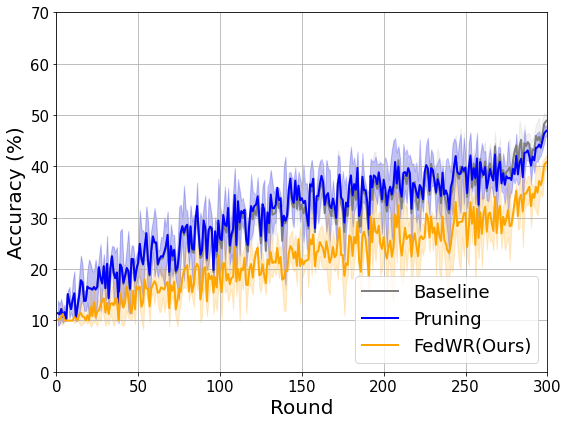

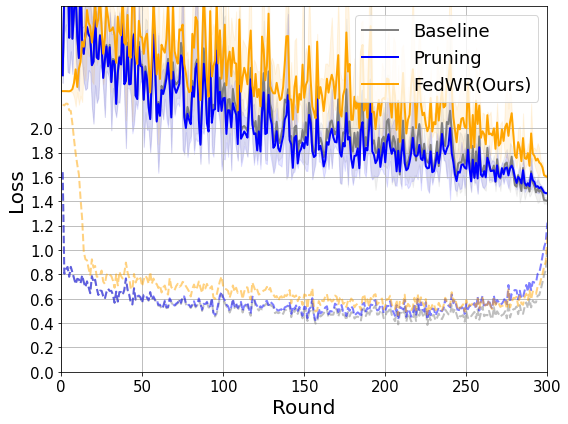

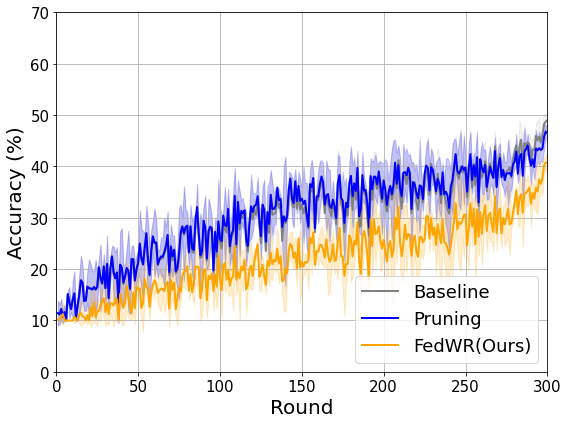

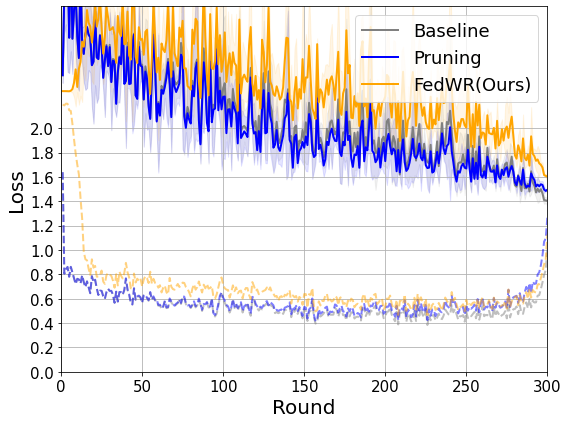

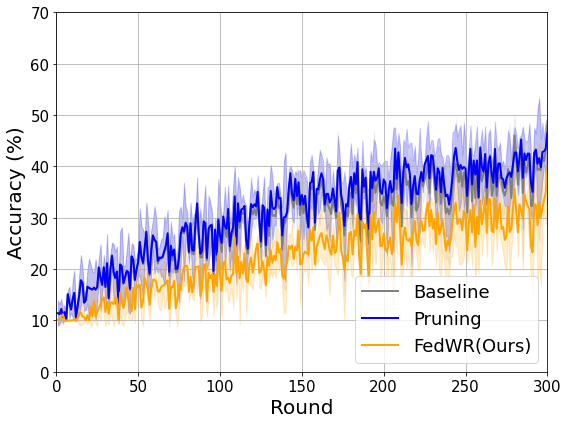

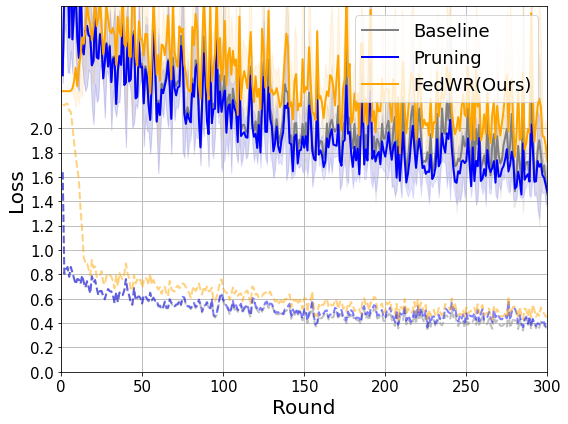

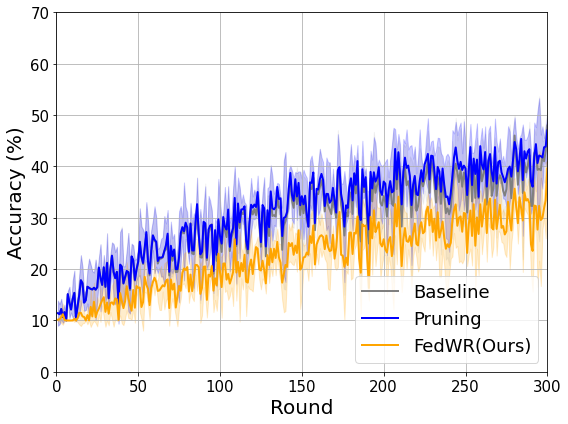

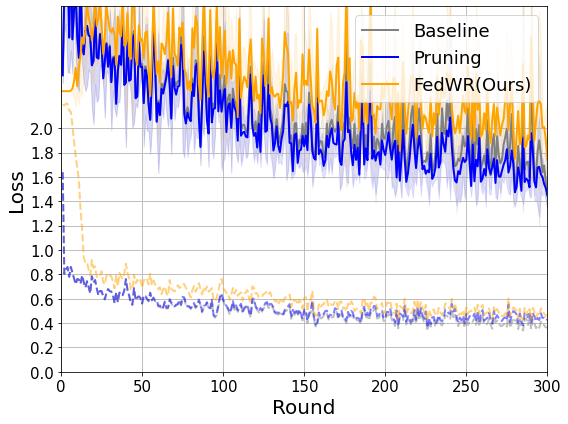

In [7]:
for mode in {'linear', 'constant'}:
    for remode in {'retraining', 'noretraining'}:
        for init in {'0001'}:
            plotter(mode, remode, init)
            print(f"Done: {mode} {remode} {init}")